### IMPORTS

In [1]:
from Inference.VariationalGNN import GNN,GNNens


In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
target_mixture = [torch.distributions.normal.Normal(-1.5, 0.1),
           torch.distributions.normal.Normal(-1., 0.2),
           torch.distributions.normal.Normal(-0.3, 0.2)]
target_proportions = torch.tensor([0.1, 0.8, 0.1])


In [4]:
def target(x):
    return torch.exp(logtarget(x))

def logtarget(x):
    logp = [None]*len(target_mixture)
    for j in range(len(target_mixture)):
        logp[j] = target_mixture[j].log_prob(x) + target_proportions[j].log()
    return torch.logsumexp(torch.cat(logp,dim=1),dim=1).unsqueeze(-1)

<IPython.core.display.Javascript object>


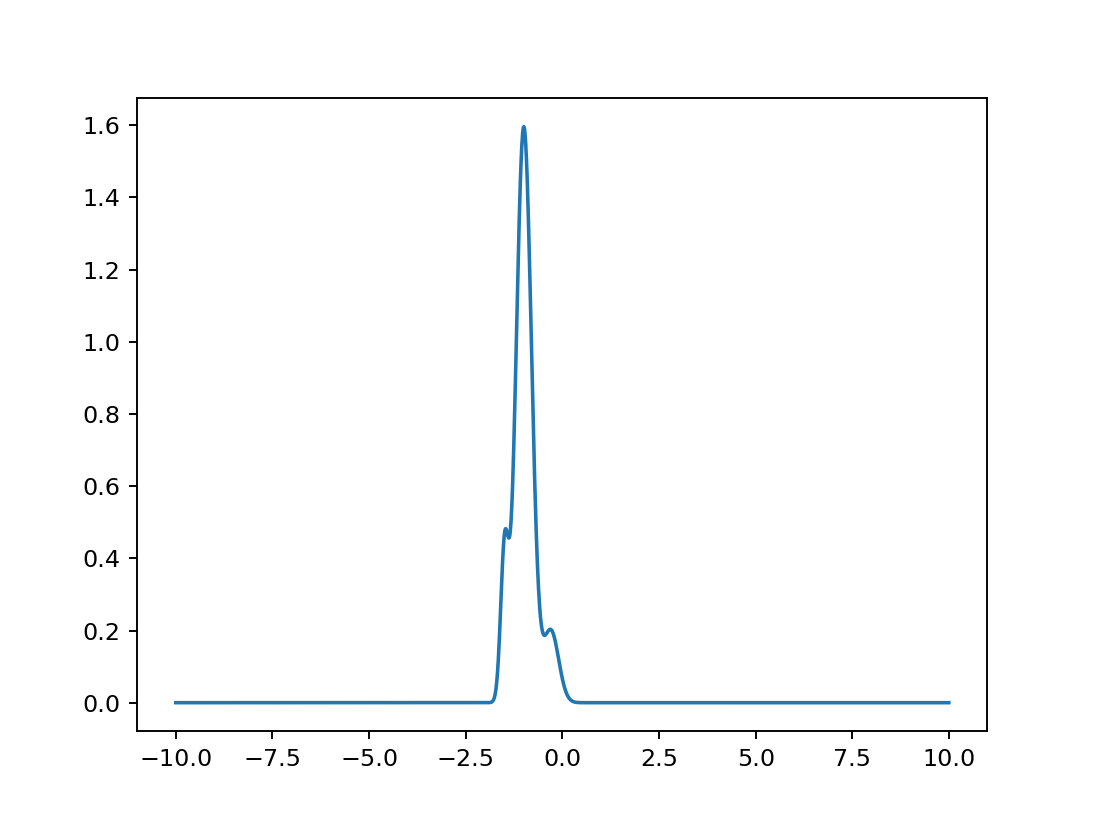

In [5]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), target(x_lin).detach().cpu().numpy())


In [6]:
G=GNNens(1,5,5,1,sigma=1.,layers=3,activation=nn.ReLU)
print('%%% Submodules %%%')
for i in G.named_modules():
    print(i)
print('%%% Parameters %%%')
for i in G.named_parameters():
    print(i)


%%% Submodules %%%
('', GNNens(
  (components): ModuleList(
    (0): GNN(
      (transformer): Sequential(
        (0): Linear(in_features=5, out_features=5, bias=True)
        (1): ReLU()
        (2): Linear(in_features=5, out_features=5, bias=True)
        (3): ReLU()
        (4): Linear(in_features=5, out_features=5, bias=True)
        (5): ReLU()
        (6): Linear(in_features=5, out_features=1, bias=True)
      )
    )
  )
))
('components', ModuleList(
  (0): GNN(
    (transformer): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
      (4): Linear(in_features=5, out_features=5, bias=True)
      (5): ReLU()
      (6): Linear(in_features=5, out_features=1, bias=True)
    )
  )
))
('components.0', GNN(
  (transformer): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    

In [7]:
def init_weightsOut(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0., std=10.)
        torch.nn.init.constant_(m.bias,0.)

for c in range(G.nb_comp):
    G.components[c].transformer[6].apply(init_weightsOut)



<IPython.core.display.Javascript object>


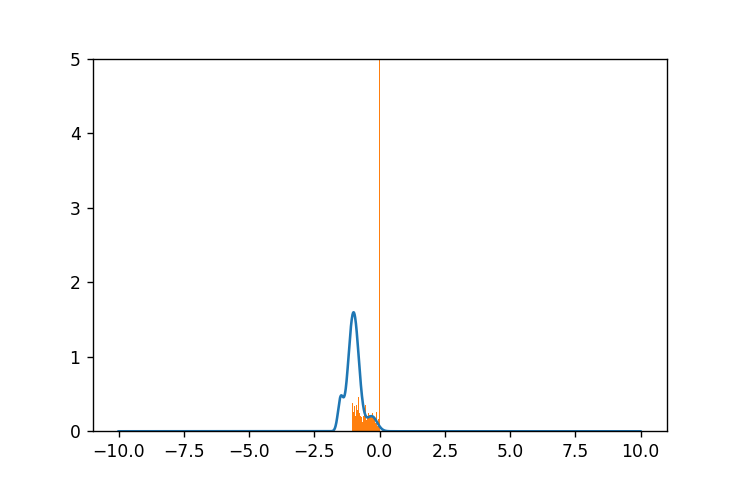

In [16]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), target(x_lin).detach().cpu().numpy())

Z = []
for i in range(5000):
    z = G()
    Z.append(z.detach().clone().cpu().squeeze().numpy())

plt.ylim(0, 5) 
plt.hist(np.stack(Z),bins=100,density=True);

In [9]:
GNN_optimizer = torch.optim.Adam(G.parameters(), lr=.1)
GNN_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(GNN_optimizer, patience=50, factor=0.5)
%matplotlib inline
liveloss = PlotLosses()

In [10]:
n_samples_VAR = 100
n_samples_KDE=200
n_samples_ED=20

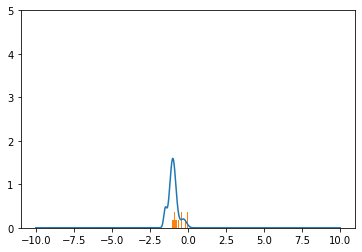

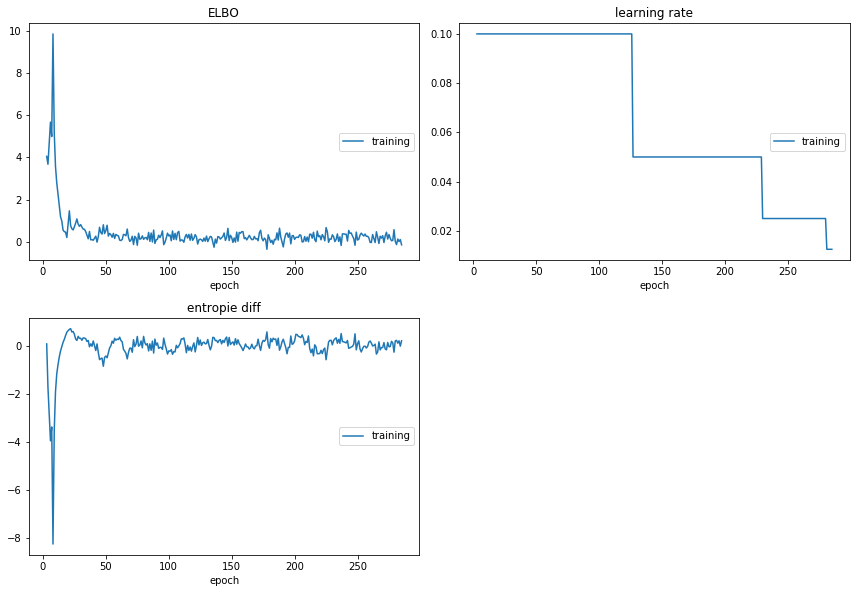

ELBO:
training   (min:   -0.361, max:   60.707, cur:   -0.149)

learning rate:
training   (min:    0.013, max:    0.100, cur:    0.013)

entropie diff:
training   (min:   -8.258, max:    2.150, cur:    0.223)


KeyboardInterrupt: 

In [15]:
%matplotlib inline
for t in range(10000):
    logs = {}
    GNN_optimizer.zero_grad()

    learning_rate = GNN_optimizer.param_groups[0]['lr']
    
    ED=G.EDKs(n_samples_KDE,n_samples_ED)
    LP=G.LPs(logtarget,n_samples_VAR)
    L =ED-LP 

    L.backward()
    

    

    GNN_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    logs['entropie diff'] = -ED.detach().clone().cpu().numpy()
    liveloss.update(logs)

   
    
    if t % 5 == 0:
        x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
        plt.plot(x_lin.detach().cpu().numpy(), target(x_lin).detach().cpu().numpy())

        Z = []
        for i in range(500):
            z = G()
            Z.append(z.detach().clone().cpu().squeeze().numpy())

        plt.ylim(0, 5) 
        plt.hist(np.stack(Z),bins=100,density=True);
        liveloss.draw()

    GNN_optimizer.step()

    if learning_rate < 0.00001:
        break